In [1]:
import os
import utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from functools import partial

In [2]:
def read_all_results(dir_path):
    paths = os.listdir(dir_path)
    last_gens = []
    for i in range(len(paths)):
        path = dir_path + paths[i]
        try:
            last_gen = sorted(map(lambda x: x.split("_"), 
                            os.listdir(f"{path}/individuals/")), 
                            key=lambda x: int(x[1].split(".")[0]))[-1][-1][:-4]
            print(f"Path: {paths[i]}, last generation: {int(last_gen)}")
            last_gens.append(int(last_gen))
        except:
            continue
    return paths, last_gens

In [3]:
dir_path = "results/"
paths, last_gens = read_all_results(dir_path)

Path: GA_2021_06_02_00_18_08, last generation: 5


In [4]:
run = 0
path = dir_path + paths[run]
with open(dir_path + paths[run] + "/run_params.json", "r") as file:
    print(file.read())
    file.close()

{
    "objective": "deaths",
    "simulations": 5,
    "process": {
        "horizon": 74,
        "decision_period": 28,
        "policy": "weighted"
    },
    "population_size": 5,
    "random_individuals": false,
    "min_generations": 0
}


## Individual results

In [5]:
gen = 5
individuals_path =  f"{path}/individuals/individuals_{gen}.pkl"
individuals = utils.read_pickle(individuals_path)

In [6]:
ordinal = lambda n: "%d%s" % (n,"tsnrhtdd"[(n//10%10!=1)*(n%10<4)*n%10::4])
print("Strategy_count:")
print(f"{utils.tcolors.BOLD}{'#':<3} {'U':<5}{'D':<5}{'N':<5}{utils.tcolors.ENDC}")
for trend_count in range(6):
    strategy_count = individuals[0].strategy_count
    print(f"{trend_count+1:<2}| {strategy_count['U'][trend_count]:<5}{strategy_count['D'][trend_count]:<5}{strategy_count['N'][trend_count]:<5}")
print()
for ix, i in enumerate(sorted(individuals, key=lambda x: x.mean_score)):
    print(f"{utils.tcolors.BOLD}{ordinal(ix+1)} place:{utils.tcolors.ENDC}")
    print(f"ID: {i.ID}")
    print(f"Score: {np.round(i.mean_score, 3)}")
    print(f"Genes:\n{np.round(i.genes, 3)}")
    print()

Strategy_count:
#   U    D    N    
1 | 5    5    5    
2 | 1    5    5    
3 | 1    4    5    
4 | 0    0    3    
5 | 0    0    1    
6 | 0    0    0    

1st place:
ID: gen_2_012
Score: 1323.549
Genes:
[[[0. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]]

 [[0. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]]

 [[0. 0. 0. 1. 0.]
  [0. 0. 0. 1. 0.]
  [0. 0. 1. 0. 0.]]]

2nd place:
ID: gen_1_004
Score: 1362.376
Genes:
[[[0.    0.    0.25  0.75  0.   ]
  [0.    0.    0.25  0.75  0.   ]
  [0.429 0.    0.143 0.429 0.   ]]

 [[0.    0.    0.25  0.75  0.   ]
  [0.    0.    0.25  0.75  0.   ]
  [0.    0.    0.25  0.75  0.   ]]

 [[0.    0.    1.    0.    0.   ]
  [0.    0.    0.25  0.75  0.   ]
  [0.    0.    0.25  0.75  0.   ]]]

3rd place:
ID: gen_5_008
Score: 1493.846
Genes:
[[[0.    0.    0.197 0.803 0.   ]
  [0.    0.    0.286 0.714 0.   ]
  [0.375 0.    0.625 0.    0.   ]]

 [[0.    0.    0.125 0.875 0.   ]
  [0.    0.132 0.124 0.744 0.   ]
  [0.    0.    0.863 0.137 0.   ]]



In [7]:
genes = np.sum(individuals[0].genes, axis=(0,1))
norm = np.sum(genes)
norm_genes = np.divide(genes, norm)
print(norm_genes)

[0.         0.         0.33333333 0.66666667 0.        ]


## Generation Means

In [8]:
generation_scores = os.listdir(path+"/final_scores/")
final_scores = []
for score in sorted(generation_scores, key=lambda x: int(x.split("_")[2][:-4])):
    final_scores.append(utils.read_pickle(path+"/final_scores/"+score))

generation_means = defaultdict(list)
for gen_scores in final_scores:
    gen_individual_means = defaultdict(list)
    for individual in gen_scores.keys():
        for objective, scores in gen_scores[individual].items():
            gen_individual_means[objective].append(np.mean(scores))
    for objective, scores in gen_individual_means.items():
        generation_means[objective].append(np.mean(scores))
generation_means = dict(generation_means)
results = pd.DataFrame(generation_means)
results.index.rename("generation", inplace=True)
results

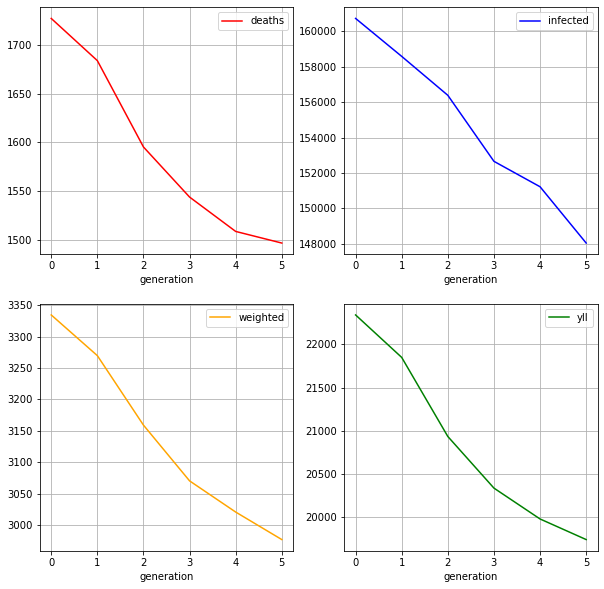

In [10]:
colors = ["red", "blue", "orange", "green"]
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(10,10))
for i, col in enumerate(results.columns):
    ax = axs[i//2][i%2]
    results[col].plot(label=col, color=colors[i], ax=ax)
    ax.legend()
    ax.grid()
plt.show()

## Best individual

In [11]:
filenames = os.listdir(path+"/best_individuals/")
best_individuals = []
for individual in sorted(filenames, key=lambda x: int(x.split("_")[2][:-4])):
    best_individuals.append(utils.read_pickle(path+"/best_individuals/"+individual))

best_individual_scores = defaultdict(partial(defaultdict, int))
for i, individual in enumerate(best_individuals):
    for obj in ["deaths", "infected", "weighted", "yll"]:
        best_individual_scores[individual.ID][obj] = np.mean(final_scores[i][individual.ID][obj])
results = pd.DataFrame(dict(best_individual_scores)).T
results.index.rename("individual", inplace=True)
results

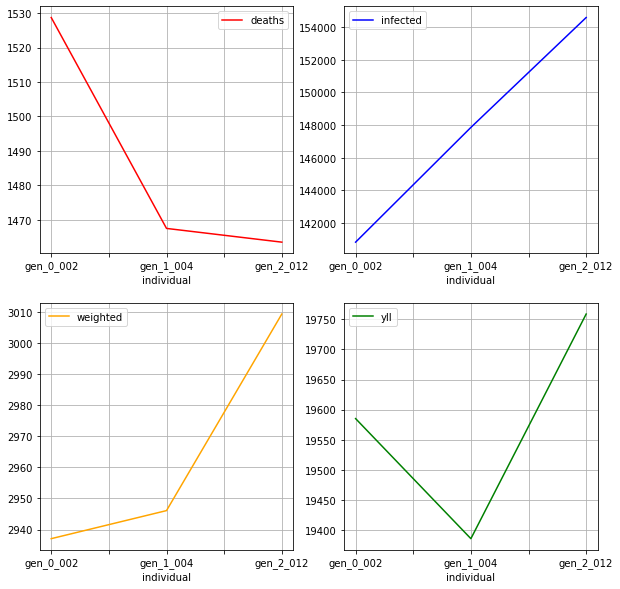

In [13]:
colors = ["red", "blue", "orange", "green"]
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(10,10))
for i, col in enumerate(results.columns):
    ax = axs[i//2][i%2]
    results[col].plot(label=col, color=colors[i], ax=ax)
    ax.legend()
    ax.grid()
plt.show()